In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

import tensorflow as tf
from tensorflow.keras import layers, models, backend

import h5py
from scipy import ndimage

# block averaging for image degradation
def block_mean(ar, fact):
    assert isinstance(fact, int), type(fact)
    sx, sy = ar.shape
    X, Y = np.ogrid[0:sx, 0:sy]
    regions = sy//fact * (X//fact) + Y//fact
    res = ndimage.mean(ar, labels=regions, index=np.arange(regions.max() + 1))
    res.shape = (sx//fact, sy//fact)
    return res



# Read the dataset, normalise and scale

In [3]:
###########################################################
# load galaxy images from hdf5 file
ndown = 4
# use first 256 galaxies as training data
with h5py.File(r"C:\UNIVIE\VU Data Science in Astrophysiks\Lec 03\DECals_galaxies.hdf5", 'r') as F:
  images = F['images_spirals'][:]
  # make grayscale
  images = np.mean(images, axis=-1)
  # downsample by 4
  imagesd = np.zeros((images.shape[0],images.shape[1]//ndown, images.shape[2]//ndown))
  for i in range( images.shape[0] ):
    imagesd[i,...] = block_mean( images[i,...], ndown )
  images = imagesd / 255

IMAGE_SIZE = images.shape[1]
CHANNELS   = 1
BATCH_SIZE = 128

###########################################################
# split into training and test data (first 32 galaxies are test data)
x_train = images[32:,:,:,None]
x_test  = images[:32,:,:,None]

###########################################################
# enable data augmentation, i.e. we randomly show the images flipped horizontally and vertically when training
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
])

###########################################################
#convert numpy arrays to tf.data.Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((x_train,x_train)).batch( BATCH_SIZE )
aug_ds = train_dataset.map( lambda x, y: (data_augmentation(x, training=True), y))

test_dataset = tf.data.Dataset.from_tensor_slices((x_test,x_test)).batch( BATCH_SIZE )

# Define the encoder

In [4]:
# define hyperparameters
EMBEDDING_DIM = 4
EPOCHS = 400

# Encoder
encoder_input = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS), name="encoder_input")
x = layers.Conv2D(32, (3, 3), strides=2, activation="relu", padding="same")(encoder_input)
x = layers.Conv2D(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(128, (3, 3), strides=2, activation="relu", padding="same")(x)
shape_before_flattening = backend.int_shape(x)[1:]  # the decoder will need this!
x = layers.Flatten()(x)
encoder_output = layers.Dense(EMBEDDING_DIM, name="encoder_output")(x)
encoder = models.Model(encoder_input, encoder_output)
encoder.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_output (Dense)          │ (None, 4)              │        32,772 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 125,444 (490.02 KB)

 Trainable params: 125,444 (490.02 KB)

 Non-trainable params: 0 (0.00 B)

# Define the decoder

In [5]:
# Decoder
decoder_input = layers.Input(shape=(EMBEDDING_DIM,), name="decoder_input")
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose( 128, (3, 3), strides=2, activation="relu", padding="same" )(x)
x = layers.Conv2DTranspose(  64, (3, 3), strides=2, activation="relu", padding="same" )(x)
x = layers.Conv2DTranspose(  32, (3, 3), strides=2, activation="relu", padding="same" )(x)
decoder_output = layers.Conv2D(CHANNELS, (3, 3), strides=1, activation="sigmoid", padding="same", name="decoder_output")(x)
decoder = models.Model(decoder_input, decoder_output)
decoder.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8192)           │        40,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 16, 16, 128)    │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 32, 32, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 64, 64, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_output (Conv2D)         │ (None, 64, 64, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 281,089 (1.07 MB)

 Trainable params: 281,089 (1.07 MB)

 Non-trainable params: 0 (0.00 B)

# Assemble the autoencoder

In [6]:
# Autoencoder
autoencoder = models.Model( encoder_input, decoder(encoder_output) ) 
autoencoder.summary()

# Compile the autoencoder
autoencoder.compile(optimizer="adam", loss="mean_squared_error")

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_output (Dense)          │ (None, 4)              │        32,772 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_4 (Functional)       │ (None, 64, 64, 1)      │       281,089 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 406,533 (1.55 MB)

 Trainable params: 406,533 (1.55 MB)

 Non-trainable params: 0 (0.00 B)

# Train the autoencoder

In [7]:
# train the autoencoder
autoencoder.fit( train_dataset, epochs=EPOCHS, shuffle=True, validation_data=test_dataset )

Epoch 1/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 321ms/step - loss: 0.1232 - val_loss: 0.1259
Epoch 2/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - loss: 0.1218 - val_loss: 0.1242
Epoch 3/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 0.1201 - val_loss: 0.1222
Epoch 4/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.1180 - val_loss: 0.1195
Epoch 5/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 0.1153 - val_loss: 0.1160
Epoch 6/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.1118 - val_loss: 0.1113
Epoch 7/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 0.1069 - val_loss: 0.1040
Epoch 8/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.0990 - val_loss: 0.0898
Epoch 9/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 0.0824 - val_loss: 0.0551
Epoch 10/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - loss: 0.0448 - val_loss: 0.0117
Epoch 11/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - loss: 0.0180 - val_loss: 0.0203
Epoch 12/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - loss: 0.0

In [8]:
# Save the final models
import os

# Check if the directory exists
if not os.path.exists("./models/"):
    # Create the directory
    os.makedirs("./models/")
autoencoder.save("./models/autoencoder.keras")
encoder.save("./models/encoder.keras")
decoder.save("./models/decoder.keras")

In [9]:
n_to_predict = 5
example_images = x_test[:n_to_predict]
predictions = autoencoder.predict(example_images)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


Thtough the convolutional autoencoder, we captured the non-linear features of data as we did in lecture notes. Also previously we captured the linear features through SVD decompositiona and reconstructing the image with lower ranks.

- In this task we specifically changed the latent space dimensions from 8 to 4.
- We used encoder layers to extract data features and reconstructed back the image from learned features using decoder layers.

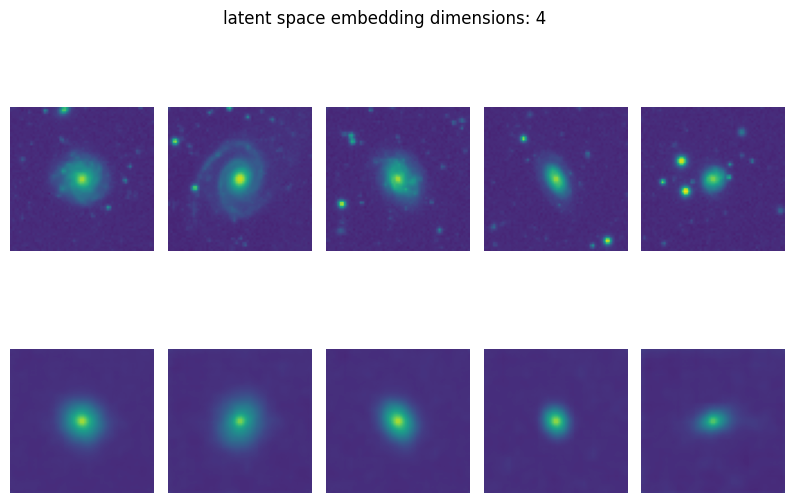

In [10]:

%matplotlib inline

fig, ax = plt.subplots(2, n_to_predict, figsize=(10, 6))

plt.suptitle(f'latent space embedding dimensions: {EMBEDDING_DIM}')

for i in range(n_to_predict):
  ax[0, i].imshow(example_images[i, ...], cmap='viridis', vmin=0, vmax=1)
  ax[0, i].axis('off')
  ax[1, i].imshow(predictions[i, ...], cmap='viridis', vmin=0, vmax=1)
  ax[1, i].axis('off')

plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()


We accessed the latent space for this specific dimensions (4), and plotted their density (frequency) in histograms.

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
(256, 4)


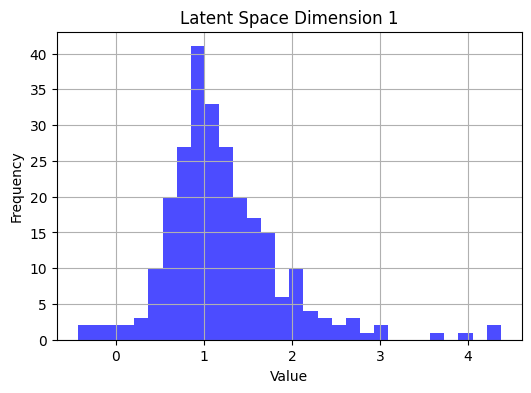

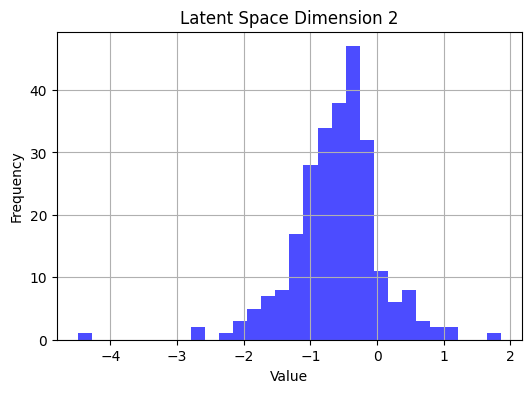

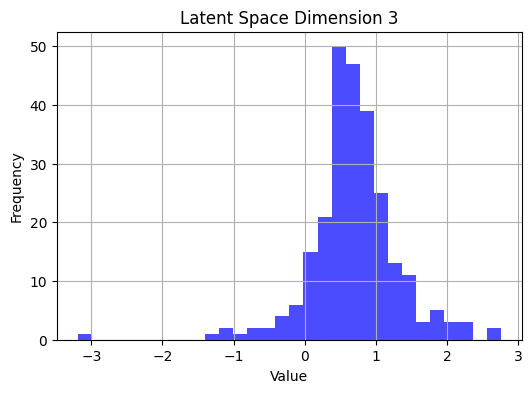

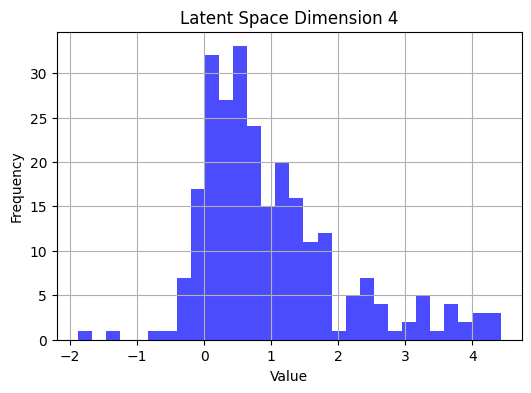

In [11]:
latent_representation = encoder.predict(images)
print(latent_representation.shape)
for i in range(EMBEDDING_DIM):
    plt.figure(figsize=(6, 4))
    plt.hist(latent_representation[:, i], bins=30, color='blue', alpha=0.7)
    plt.title(f'Latent Space Dimension {i+1}')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

Here using decoder part of the autoencoder, images representing first (4) latent space values were generated. The image represented such that taking 1 dimension 0 and other to any optional value here (2).

- By these images we can have important featires of galaxy images such as: dimensions, shape, brightness (luminousity), orientations and may other features.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


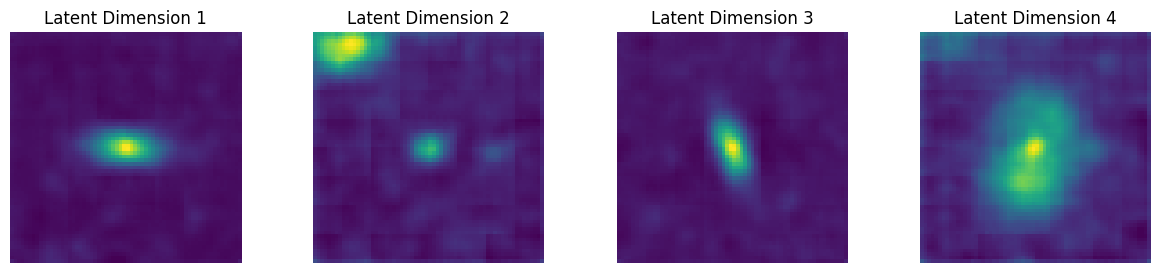

In [13]:
import numpy as np

# Define latent space values with all dimensions set to zero except one
latent_values_list = []
num_latent_dimensions = EMBEDDING_DIM  # Number of dimensions in the latent space

for i in range(num_latent_dimensions):
    latent_values = np.zeros((1, EMBEDDING_DIM))  # Initialize all values to zero
    latent_values[0, i] = 2.0  # Set one dimension to a specific value, others remain zero
    latent_values_list.append(latent_values)

# Generate images from each set of latent space values
generated_images_list = []
for latent_values in latent_values_list:
    generated_image = decoder.predict(latent_values)
    generated_images_list.append(generated_image)


fig, axs = plt.subplots(1, num_latent_dimensions, figsize=(15, 3))
for i, generated_image in enumerate(generated_images_list):
    axs[i].imshow(generated_image.squeeze(), cmap='viridis')
    axs[i].axis('off')
    axs[i].set_title(f"Latent Dimension {i+1}")

plt.show()